In [1]:
# pip install torch numpy matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import copy
import random

# set random seed
fix_seed = 2024
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

from Autoregressive import Model as ARMAAttn
from iTransformer import Model as iTransformer

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

data_orig = pd.read_csv('fuser_and_metar.csv')
data_orig = data_orig.set_index('prediction_time')
scaler = MinMaxScaler()
scaler.fit(data_orig)
data = pd.DataFrame(scaler.transform(data_orig), columns=data_orig.columns, index=data_orig.index)
data

,cloud_ceiling_KATL,cloud_ceiling_KCLT,cloud_ceiling_KDEN,cloud_ceiling_KDFW,cloud_ceiling_KJFK,cloud_ceiling_KMEM,cloud_ceiling_KMIA,cloud_ceiling_KORD,cloud_ceiling_KPHX,cloud_ceiling_KSEA,...,actual_departures_KATL,actual_departures_KCLT,actual_departures_KDEN,actual_departures_KDFW,actual_departures_KJFK,actual_departures_KMEM,actual_departures_KMIA,actual_departures_KORD,actual_departures_KPHX,actual_departures_KSEA
prediction_time,,,,,,,,,,,,,,,,,,,,,
9/1/2022 0:00,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,...,0.542857,0.250000,0.500000,0.424242,0.473684,0.068966,0.380952,0.235294,0.45,0.5625
9/1/2022 0:15,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,...,0.428571,0.428571,0.472222,0.272727,0.684211,0.068966,0.523810,0.176471,0.20,0.4375
9/1/2022 0:30,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,...,0.485714,0.642857,0.472222,0.424242,0.631579,0.034483,0.523810,0.294118,0.00,0.3125
9/1/2022 0:45,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,...,0.228571,0.500000,0.305556,0.454545,0.578947,0.000000,0.380952,0.500000,0.15,0.6875
9/1/2022 1:00,1.0,1.0,1.0,0.875,1.0,1.0,1.000,1.0,1.0,1.000,...,0.428571,0.678571,0.333333,0.424242,0.210526,0.034483,0.333333,0.558824,0.15,0.5625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8/31/2023 22:45,1.0,1.0,1.0,1.000,1.0,1.0,0.875,1.0,1.0,0.625,...,0.514286,0.357143,0.361111,0.272727,0.631579,0.034483,0.238095,0.264706,0.35,0.3750
8/31/2023 23:00,1.0,1.0,1.0,1.000,1.0,1.0,0.875,1.0,1.0,0.625,...,0.342857,0.428571,0.222222,0.424242,0.684211,0.068966,0.380952,0.352941,0.55,0.8750
8/31/2023 23:15,1.0,1.0,1.0,1.000,1.0,1.0,0.875,1.0,1.0,0.625,...,0.257143,0.464286,0.222222,0.272727,0.368421,0.103448,0.523810,0.617647,0.75,0.5625


In [3]:
from torch.utils.data import Dataset
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import numpy as np
import random
import copy
import warnings

class FlightDataset(Dataset):
    def __init__(self, df, flag='train', input_window=4, output_window=12, number_of_targets=20, train_ratio=0.8, n_jobs=-1):
        self.data = df
        self.input_window = input_window
        self.output_window = output_window
        self.number_of_targets = number_of_targets
        self.train_ratio = train_ratio
        self.flag = flag
        self.data_train = []
        self.data_test = []
        self.n_jobs = n_jobs  # Number of parallel jobs
        self._pre_scan()
        self._train_val_split()
        self.set_dataset_type()

    def data_provider(self, index, return_datetime=False):
        input_window = self.input_window
        output_window = self.output_window
        window = input_window + output_window
        number_of_targets = self.number_of_targets
        data = self.data

        data_input = data.iloc[index:index+input_window, -number_of_targets:].to_numpy(dtype=np.float32)
        data_output = data.iloc[index+input_window:index+window, -number_of_targets:].to_numpy(dtype=np.float32)
        data_exog = data.iloc[index:index+window, 0:-number_of_targets].to_numpy(dtype=np.float32)
        data_datetime = data.iloc[index+input_window:index+window].index
        if return_datetime:
            return data_datetime
        return data_input, data_output, data_exog, index

    def _process_row(self, i):
        data_input, data_output, data_exog, data_datetime = self.data_provider(i)
        if not (data_input.shape[0] == self.input_window and data_output.shape[0] == self.output_window and data_exog.shape[0] == self.input_window + self.output_window):
            return None
        if not np.any(data_input):
            return None
        if not np.any(np.all(data_output == 0, axis=1)):
            return ('train', (data_input, data_output, data_exog, data_datetime))
        elif not np.any(data_output):
            return ('test', (data_input, data_output, data_exog, data_datetime))
        else:
            return None

    def _pre_scan(self):
        print('Train / Test Splitting...', end=' ')
        results = Parallel(n_jobs=self.n_jobs, batch_size=10)(
            delayed(self._process_row)(i) for i in tqdm(range(self.data.shape[0]))
        )
        
        for result in results:
            if result is None:
                continue
            dataset_type, data_entry = result
            if dataset_type == 'train':
                self.data_train.append(data_entry)
            elif dataset_type == 'test':
                self.data_test.append(data_entry)

        print('Finished')

    def _train_val_split(self):
        print('Train / Validation Splitting...', end=' ')
        random.shuffle(self.data_train)
        split_index = int(len(self.data_train) * self.train_ratio)
        self.data_val = self.data_train[split_index:]
        self.data_train = self.data_train[:split_index]
        print('Finished')

    def set_dataset_type(self, flag=None):
        if flag is not None:
            self.flag = flag
        self.dataset = {'train': self.data_train,
                        'val': self.data_val,
                        'test': self.data_test}[self.flag]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):  # Fix typo in method name
        return self.dataset[index]

# Example usage
dataset_train = FlightDataset(data, flag='train', input_window=4, output_window=12, number_of_targets=20, train_ratio=0.8, n_jobs=-1)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, pin_memory=True, drop_last=False)
dataset_val = copy.deepcopy(dataset_train)
dataset_val.set_dataset_type('val')
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, pin_memory=True, drop_last=False)
dataset_test = copy.deepcopy(dataset_train)
dataset_test.set_dataset_type('test')
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=False, pin_memory=True, drop_last=False)

Train / Test Splitting... 

  0%|          | 0/35040 [00:00<?, ?it/s]

Finished
Train / Validation Splitting... Finished


In [4]:
print(dataset_train.__len__())
print(dataset_val.__len__())
print(dataset_test.__len__())

19443
4861
489


In [5]:
def model_forward_ARMA(model, d):
    device = next(model.parameters()).device
    data_input, data_output, data_exog, data_datetime = d
    data_input = data_input.to(device)
    data_output = data_output.to(device)
    data_exog = data_exog.to(device)
    data_datetime = data_datetime.to(device)
    B, LI, Ct = data_input.shape
    _, LP, _ = data_output.shape
    _, L, Ce = data_exog.shape
    assert L == LI + LP
    C = Ce + Ct
    data_full = torch.zeros(B, L, C, device=data_input.device)
    data_full[:, 0:LI, -Ct:] = data_input
    data_full[:, :, 0:Ce] = data_exog
    model_output = torch.zeros(B, LP, Ct, device=data_input.device)

    total_loss = 0

    for ci in range(LP):
        if model.training:
            output, loss = model(data_full[:, 0:LI+ci])
        else:
            output = model(data_full[:, 0:LI+ci]) # B 1 Ct
        if ci == 0 and model.training:
            total_loss = total_loss + loss

        model_output[:, ci] = output[:, 0]
        data_full[:, LI+ci, -Ct:] = output[:, 0].detach()

    mse_loss = F.mse_loss(model_output, data_output)

    return model_output, mse_loss

class ARMAConfig:
    seq_len = 32                 # L_I, length of input
    pred_len = 1                 # L_P, forecasting horizon
    
    label_len = seq_len           # placeholder for predictors with encoder-decoder structure
    enc_in = 210                    # C, number of input series
    number_of_targets = 20
    d_model = 64
    dropout = 0.1
    ma_dropout = 0.1
    e_layers = 3
    n_heads = 8
    predictor = 'LinearAttentionARMA'
    time_emb_dim = 0              # no timestamp embedding by default
    features = 'M'

def model_forward_iTransformer(model, d):
    device = next(model.parameters()).device
    data_input, data_output, data_exog, data_datetime = d
    data_input = data_input.to(device)
    data_output = data_output.to(device)
    data_exog = data_exog.to(device)
    data_datetime = data_datetime.to(device)
    B, LI, Ct = data_input.shape
    _, LP, _ = data_output.shape
    _, L, Ce = data_exog.shape
    assert L == LI + LP
    C = Ce + Ct
    data_full = torch.zeros(B, L, C, device=data_input.device)
    data_full[:, 0:LI, -Ct:] = data_input
    data_full[:, :, 0:Ce] = data_exog

    model_output = model(data_full, None, None, None)
    model_output = model_output[:, :, -Ct:]

    mse_loss = F.mse_loss(model_output, data_output)
    return model_output, mse_loss

class iTransformerConfig:
    seq_len = 16
    pred_len = 12
    output_attention = False
    use_norm = True
    d_model = 512
    d_ff = 2048
    n_heads = 8
    embed = None
    freq = None
    dropout = 0.1
    factor = None
    e_layers = 3
    activation = "gelu"
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Build CATS model
model_type = 'ARMA'
model_config = {'ARMA': ARMAConfig, 'iTransformer': iTransformerConfig}[model_type]()
model = {'ARMA': ARMAAttn, 'iTransformer': iTransformer}[model_type](model_config).to(device)
model_forward = {'ARMA': model_forward_ARMA, 'iTransformer': model_forward_iTransformer}[model_type]
if torch.cuda.is_available() and torch.__version__ > '2.0':
    model = torch.compile(model)
    
# for d in dataloader_train:
#     print(model_forward(model, d))
#     break

Using device: cuda


In [6]:
import time
import matplotlib.pyplot as plt

initial_lr = 0.0001
optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=0.00001)
num_epochs = 200

#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1 - epoch / num_epochs)
warmup_epochs = num_epochs // 20
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, 
    lr_lambda=lambda epoch: epoch / warmup_epochs if epoch <= warmup_epochs else (1 - (epoch - warmup_epochs) / (num_epochs - warmup_epochs))
)

model.train()
epoch_losses = []
validation_losses = []

for epoch in range(num_epochs):
    start_time = time.time()
    total_loss = 0
    num_batches = 0

    # Training loop
    for d in dataloader_train:
        optimizer.zero_grad()
        output, loss = model_forward(model, d)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        if num_batches % 50 == 0:
            elapsed_time = time.time() - start_time
            print(f'Epoch {epoch+1}, Step {num_batches}, Average Loss: {total_loss / num_batches:.4f}, Elapsed Time: {elapsed_time:.2f} sec')

    scheduler.step()

    average_loss = total_loss / num_batches
    epoch_losses.append(average_loss)
    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch+1},          Average Loss: {average_loss:.4f}, Total Elapsed Time: {elapsed_time:.2f} sec")

    # Validation loop
    model.eval()
    val_total_loss = 0
    val_num_batches = 0

    with torch.no_grad():
        for d in dataloader_val:
            output, loss = model_forward(model, d)
            val_total_loss += loss.item()
            val_num_batches += 1

    val_average_loss = val_total_loss / val_num_batches
    validation_losses.append(val_average_loss)
    print(f"Epoch {epoch+1}, Validation Loss: {val_average_loss:.4f}")

    model.train()

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()

/root/miniconda3/envs/myenv/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:167: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


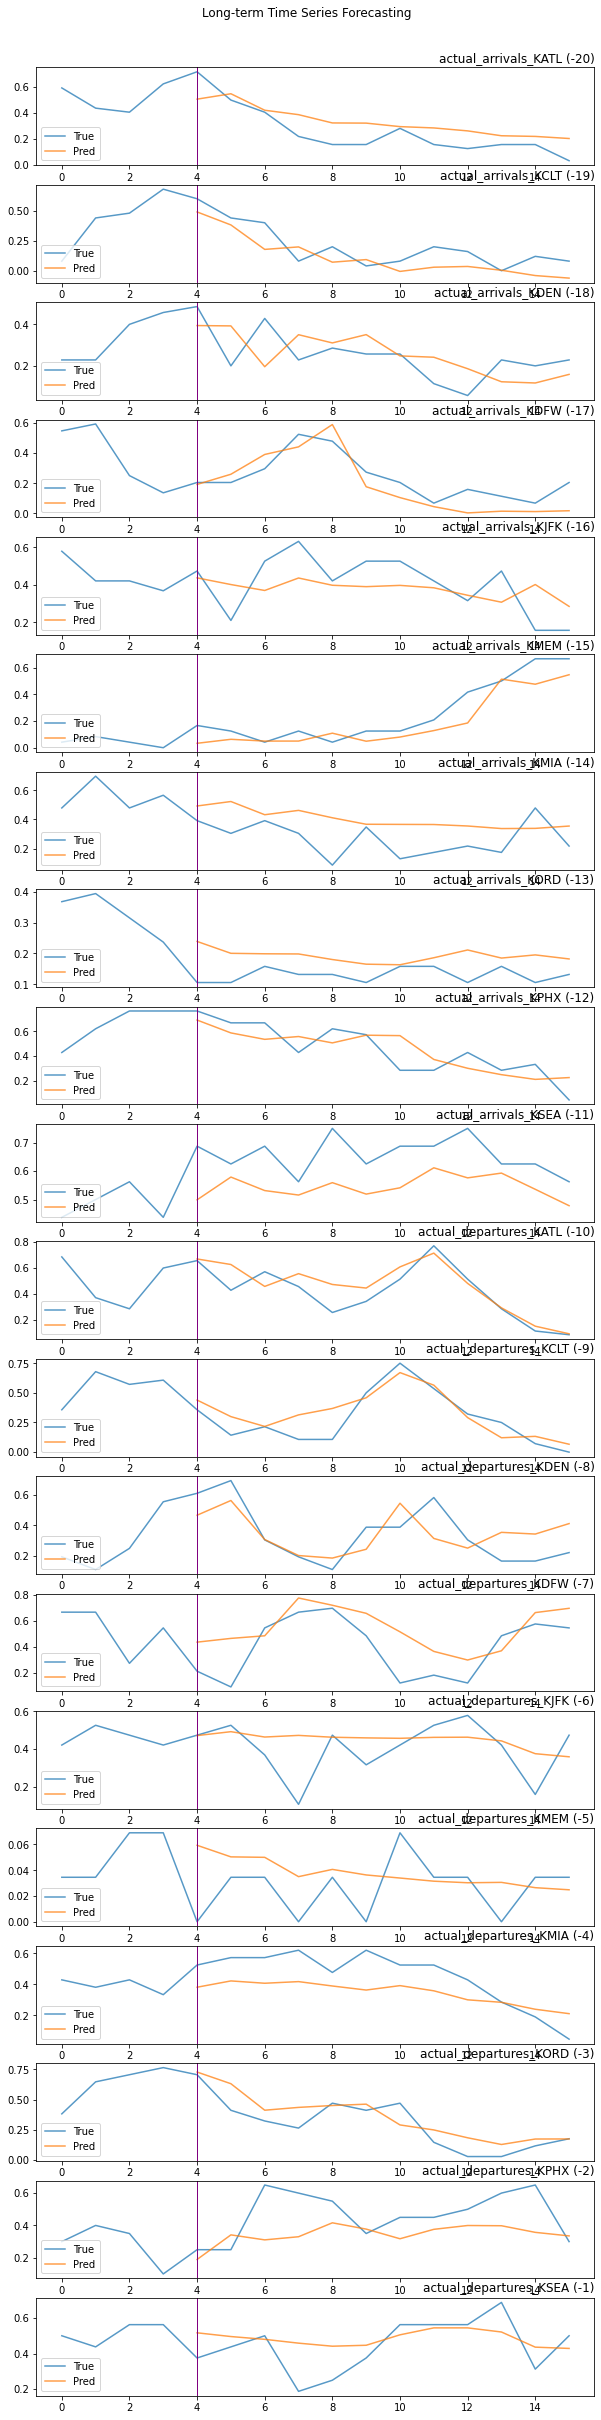

In [7]:
model.eval()

def mts_visualize(pred, true, split_step=720, title='Long-term Time Series Forecasting', dpi=72, col_names=None):
    groups = range(true.shape[-1])
    C = true.shape[-1]
    i = 1
    # plot each column
    f = plt.figure(figsize=(10, 2.1*len(groups)), dpi=dpi)
    f.suptitle(title, y=0.9)
    index = 0
    for group in groups:
        plt.subplot(len(groups), 1, i)
        plt.plot(true[:, group], alpha=0.75, label='True')
        if type(pred) is list:
            for index, p in enumerate(pred):
                plt.plot(list(range(split_step, true.shape[0])), p[:, group], alpha=0.5, label=f'Pred_{index}')
        else:
            plt.plot(list(range(split_step, true.shape[0])), pred[:, group], alpha=0.75, label='Pred')
        #plt.title(f'S{i}', y=1, loc='right')
        if col_names is None or C-index > len(col_names):
            plt.title(f"Series (-{C-index})", y=1, loc='right')
        else:
            plt.title(f"{col_names[-(C-index)]} (-{C-index})", y=1, loc='right')
        index += 1
        plt.legend(loc='lower left')
        plt.axvline(x=split_step, linewidth=1, color='Purple')
        i += 1
    return f

with torch.no_grad():
    for d in dataloader_val:
        output, loss = model_forward(model, d)
        ground_truth = torch.cat([d[0], d[1]], dim=1).to(output.device)
        mts_visualize(output[0].detach().cpu().numpy(), 
                      ground_truth[0].detach().cpu().numpy(), 
                      split_step=4, col_names=data.columns.tolist()[-20:])
        break

In [8]:
# torch.save(model, 'model.pkl')

In [12]:
pred_results = []
model.eval()

with torch.no_grad():
    for d in tqdm(dataloader_test):
        output, loss = model_forward(model, d)
        indices = d[3].detach().cpu().numpy().tolist()
        date_indices = [data.index[i+4:i+16].to_series() for i in indices]
        B, L, C = output.shape
        output = output.reshape(B*L, C)
        output_full = torch.zeros(B*L, 210)
        output_full[:, -20:] = output
        output = scaler.inverse_transform(output_full.detach().cpu().numpy())[:, -20:]
        output = pd.DataFrame(output, columns=data.columns[-20:]).clip(0, None)
        date_indices = pd.concat(date_indices).reset_index(drop=True)
        result = pd.concat([date_indices, output], axis=1)
        pred_results.append(result)

pd.concat(pred_results)

Train / Test Splitting... 

  0%|          | 0/35040 [00:00<?, ?it/s]

Finished
Train / Validation Splitting... Finished


  0%|          | 0/4 [00:00<?, ?it/s]

,prediction_time,actual_arrivals_KATL,actual_arrivals_KCLT,actual_arrivals_KDEN,actual_arrivals_KDFW,actual_arrivals_KJFK,actual_arrivals_KMEM,actual_arrivals_KMIA,actual_arrivals_KORD,actual_arrivals_KPHX,...,actual_departures_KATL,actual_departures_KCLT,actual_departures_KDEN,actual_departures_KDFW,actual_departures_KJFK,actual_departures_KMEM,actual_departures_KMIA,actual_departures_KORD,actual_departures_KPHX,actual_departures_KSEA
0,9/25/2022 1:00,6.718460,1.779906,18.585419,9.692423,6.557556,0.478433,6.375961,8.924648,6.800401,...,12.350954,16.052860,9.335163,15.109040,12.185072,0.102582,4.036115,11.799588,4.691649,8.649460
1,9/25/2022 1:15,9.061849,3.607471,19.499819,7.762367,9.036297,1.516799,6.239002,8.134187,6.000031,...,15.994430,6.577548,22.794590,4.662572,11.686513,0.769004,3.665393,12.467839,5.219837,7.757709
2,9/25/2022 1:30,6.184971,2.376346,6.688132,9.326539,8.522903,8.078724,7.213115,7.681167,4.485425,...,11.320542,5.521857,23.012423,0.000000,10.637152,0.224945,6.381963,7.807141,7.469425,6.850924
3,9/25/2022 1:45,4.351005,3.189427,2.232939,9.241998,10.365468,2.813044,5.809566,8.463634,4.877370,...,7.538803,6.717905,11.238556,12.503693,9.279883,0.159938,3.809511,7.192306,8.669503,5.800155
4,9/25/2022 2:00,3.249990,2.969495,0.000000,5.708735,8.079079,2.578880,5.485032,6.716146,2.958498,...,10.180667,4.422162,4.731954,14.851168,9.244202,0.092891,4.978348,6.984654,7.187127,6.176906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,8/18/2023 22:45,13.208809,9.100466,15.173921,20.312092,8.392407,1.130308,10.462821,12.132906,5.792678,...,12.112848,8.710607,10.805343,10.947274,6.865089,4.392991,2.169317,11.943755,5.495143,9.436431
1256,8/18/2023 23:00,11.362438,5.297323,12.669749,6.789346,8.231419,1.166655,7.252198,10.703839,5.761005,...,12.466258,6.555656,10.377131,9.635550,8.176670,4.964441,1.641341,11.949945,4.424847,11.600220
1257,8/18/2023 23:15,11.243839,7.372949,13.273326,2.289865,8.708784,0.981695,7.910148,12.554977,4.594854,...,10.420817,2.372329,10.652877,10.087703,8.946296,4.695223,1.473251,11.619694,6.769319,9.400988
1258,8/18/2023 23:30,12.363366,4.226455,15.792558,0.821864,8.791541,0.080650,7.727857,10.295506,4.317967,...,10.604200,1.564347,9.756967,12.925824,7.442833,4.245212,1.284772,12.508755,5.760236,6.097846


In [13]:
pd.concat(pred_results).to_csv('flight_result_linearattentionarma.csv')

In [3]:
# import pandas as pd
# final_result = pd.read_csv('final_submission.csv')
# final_result['Value']= final_result['Value'].replace(99.0, 0)
# final_result.to_csv('final_submission_fixed.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'final_submission505.csv'